# Part 01A: Introduction to Regression with Neural Network in tensorflow

Contents:
- Polynomial model, OLS, sklearn LinearRegression, Basic Tensorflow regression

**Note**:
- Predicting probabilities can also be somewhat categorized as a regression problem (`RidgeClassifier` in sklearn)
- As we are predicting a continous bounded output between 0 and 1 (probabilities)
- It all depends on how you choose your outputs and the loss function
    - Yes, you can choose a mean squared error for loss function between predicted probabilities and the actual ground truth output. (It just won't be the maximum likelihood output)
    
    
    

In [1]:
# Import tensorflow
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
!nvidia-smi

Tue Apr 27 13:21:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.56       Driver Version: 452.56       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX350      WDDM  | 00000000:30:00.0 Off |                  N/A |
| N/A   55C    P0    N/A /  N/A |     68MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Polynomial Class

In [3]:
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [4]:
class PolynomialModel:
    
    def __init__(self, params, stderr):
        self.params = params
        self.stderr = stderr
        self.degree = len(self.params) - 1
        
    def __call__(self, X: np.array, add_noise=False):
        
        val = 0.0
        for i, p in enumerate(self.params):
            val += (X**i)*p
            
        val = np.sum(val, axis=1) # DOUBT: Should y be a 2D Matrix?
            
        if add_noise:
            val += self._sample_normal_noise(self.stderr, shape=(val.shape[0],))
            
        return val
    
            
    @staticmethod
    def _sample_normal_noise(stderr, shape=None):
        return np.random.normal(loc=0, scale=stderr, size=shape)
    

    def plot(self, X: np.array, ax=None, **kwargs):
        
        if ax is None:
            fig, ax = plt.subplots()
            
        y = self(X)
        
        ax.plot(X.flatten(), y.flatten(), **kwargs)
        
        return ax
    
    
    
        

## Create data to view and fit

Note that features in the real world are sampled from the population in most cases That means even though we consider them as non stochastic while modelling, since we have to explain the effect of X on y, these are generally not the result of a carefully controlled experiment in which we tinker with X. Infact, the business problem defines what we choose as X and what we choose as y.


In [5]:
xmin, xmax = -10, 40 # range
m = 1000 # no of data points
X = np.expand_dims(np.linspace(xmin, xmax, m), axis=-1) # You can randomly sample as well

# Create the labels aka the outputs (dependent variable)
polymodels = {}
polymodels['linear'] = PolynomialModel([2, 3], 5)
polymodels['quadratic'] = PolynomialModel([1, 2, -0.1], 10)

# Now sample some y
ys = {}
ys['linear'] = polymodels['linear'](X, add_noise=True)
ys['quadratic'] = polymodels['quadratic'](X, add_noise=True)


In [6]:
X.shape, ys['linear'].shape, ys['quadratic'].shape

((1000, 1), (1000,), (1000,))

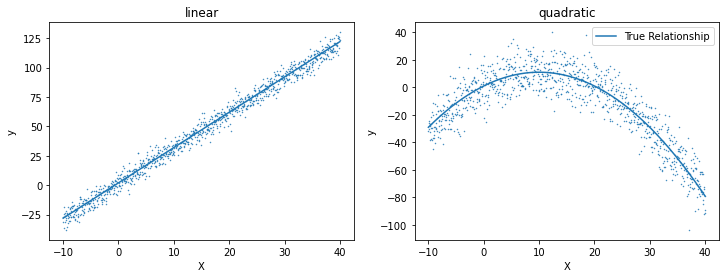

In [7]:
# Plot!
fig, axn = plt.subplots(1, 2, figsize=(12, 4))

for ax, modtype in zip(axn, ['linear', 'quadratic']):
    
    y = ys[modtype]
    polymodel = polymodels[modtype]
    
    ax.scatter(X.flatten(), y.flatten(), s=0.2)
    polymodel.plot(X, ax=ax, label='True Relationship')
    
    ax.set_title(modtype)

    ax.set_xlabel('X')
    ax.set_ylabel('y')

plt.legend();

## OLSRegressor

In [8]:
class OLSRegressor:
    
    def __init__(self, degree=1, add_bias=True):
        
        if degree != 1:
            raise NotImplementedError('Providing a degree other than 1 is not implemented yet!')
        
        self._check_degree(degree)
        
        self.degree = degree
        self.add_bias = add_bias
        
        
    def fit(self, X, y):
        if self.add_bias:
            X = self._add_bias(X)
            
        params = np.linalg.inv(X.T@X)@X.T@y
        
        if self.add_bias:
            self.intercept_, self.coef_ = params[0:1], params[1:]
        else:
            self.intercept_, self.coef_ = np.array([0.0]), params
            
    def predict(self, X):
        beta_hat = np.expand_dims(np.concatenate([self.intercept_, self.coef_]), axis=-1)
        if self.add_bias:
            X = self.add_bias(X)
            
        return X@beta_hat
        
    @staticmethod
    def _add_bias(X):
        bias = np.ones(shape=(X.shape[0], 1))
        return np.hstack((bias, X))
        
    @staticmethod
    def _check_degree(degree):
        assert type(degree) is int, 'Please provided an integer value for degree'
        assert degree >= 0, 'Please provide a positive value for degree'
        
    

#### Linear model

In [9]:
olsmodels = {}

In [10]:
olsmodel = OLSRegressor(add_bias=True)
olsmodel.fit(X, ys['linear'])
olsmodels['linear'] = olsmodel
olsmodel.intercept_, olsmodel.coef_

(array([1.83345236]), array([2.98801215]))

#### Quadratic model

In [11]:
olsmodel = OLSRegressor(add_bias=True)
olsmodel.fit(np.hstack([X, X**2]), ys['quadratic'])
olsmodels['quadratic'] = olsmodel
olsmodel.intercept_, olsmodel.coef_

(array([0.11292078]), array([ 2.07431224, -0.10153367]))

## sklearn `LinearRegression` Estimate

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
linregmodels = {}

#### Linear model

In [14]:
linregmodel = LinearRegression()
linregmodel.fit(X, y)
linregmodels['linear'] = linregmodel
linregmodel.intercept_, linregmodel.coef_

(1.7628005007690497, array([-0.97169772]))

#### Quadratic model

In [15]:
linregmodel = LinearRegression()
linregmodel.fit(np.hstack([X, X**2]), y)
linregmodels['quadratic'] = linregmodel
linregmodel.intercept_, linregmodel.coef_

(0.11292078464846078, array([ 2.07431224, -0.10153367]))

## Minimizing any function in Tensorflow

#### Minimize $y=x^2$

In [16]:
x = tf.Variable(2.)

def f(x):
    return x*x

with tf.GradientTape() as tape:
    tape.watch(x)
    
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
xvals = []
for i in range(30):
    opt.minimize(lambda : f(x), var_list=[x])
    xvals.append(x.numpy())
    
    

In [17]:
fvals = list(map(f, xvals))

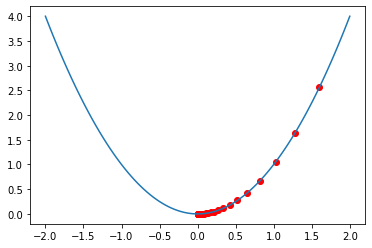

In [18]:
pm = PolynomialModel([0, 0, 1], stderr=0) # For y = x^2
Xvals = np.expand_dims(np.linspace(-2, 2, 100), axis=-1)
ax = pm.plot(Xvals)
ax.scatter(xvals, fvals, color='red')

## Fitting Simple Linear Regression model with tensorflow

In [19]:
# Choose linear true relationship
polymodel = polymodels['linear']
polymodel.params, polymodel.stderr

([2, 3], 5)

In [20]:
intercept = tf.Variable(polymodel.params[0], dtype=tf.float32)
slope = tf.Variable(polymodel.params[1], dtype=tf.float32)

def predict(intercept, slope, X):
    m = PolynomialModel([intercept, slope], stderr=0)
    return m(X)

def mse(labels, preds):
    return tf.keras.losses.mse(labels, preds)
    
def loss_func(intercept, slope, X, y):
    predictions = predict(intercept, slope, X)
    return mse(y, predictions)

with tf.GradientTape() as tape:
    tape.watch(intercept)
    tape.watch(slope)
    
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
for i in range(20):
    opt.minimize(lambda : loss_func(intercept, slope, X, y), var_list=[intercept, slope])

ValueError: ignored

In [ ]:
PolynomialModel([intercept, slope], stderr=0)(np.array([[1]]))

array([5.], dtype=float32)

In [ ]:
loss_func(intercept, slope, X, y)

<tf.Tensor: shape=(), dtype=float64, numpy=25.98332252935519>

In [ ]:
np.sum()

TypeError: _sum_dispatcher() missing 1 required positional argument: 'a'